In [1]:
directory = '/Users/davidkarapetyan/Documents/workspace/data_analysis/'
csv_file = 'data/park345_oa_temp.csv'

import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import numpy as np
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.statespace.sarimax as sarimax

# plot inline
%pylab inline
# IPython.get_ipython().magic('matplotlib inline')
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 14, 6


# load dataframe, and subset out relevant columns
park_data = pd.read_csv(directory + csv_file, error_bad_lines=False)
park_data.columns = ['ID', 'TIMESTAMP',
'TRENDFLAGS', 'STATUS',
'VALUE', 'TRENDFLAGS_TAG',
'STATUS_TAG']
park_data = park_data.sort('TIMESTAMP')


# construct time series, getting rid of microseconds
park_ts = pd.Series(list(park_data.VALUE),
pd.DatetimeIndex(park_data.TIMESTAMP),
name="steam values")

park_ts = park_ts.loc[park_ts != 0].resample('15Min').interpolate()
print(park_ts)

Populating the interactive namespace from numpy and matplotlib
2013-03-20 07:00:00    33.250000
2013-03-20 07:15:00    32.969002
2013-03-20 07:30:00    32.905998
2013-03-20 07:45:00    33.188000
2013-03-20 08:00:00    33.469002
2013-03-20 08:15:00    33.125000
2013-03-20 08:30:00    33.250000
2013-03-20 08:45:00    33.500000
2013-03-20 09:00:00    34.375000
2013-03-20 09:15:00    35.219002
2013-03-20 09:30:00    35.469002
2013-03-20 09:45:00    35.625000
2013-03-20 10:00:00    36.094002
2013-03-20 10:15:00    35.780998
2013-03-20 10:30:00    35.250000
2013-03-20 10:45:00    35.625000
2013-03-20 11:00:00    35.625000
2013-03-20 11:15:00    35.844002
2013-03-20 11:30:00    36.375000
2013-03-20 11:45:00    37.313000
2013-03-20 12:00:00    37.530998
2013-03-20 12:15:00    37.438000
2013-03-20 12:30:00    37.688000
2013-03-20 12:45:00    37.688000
2013-03-20 13:00:00    38.750000
2013-03-20 13:15:00    38.500000
2013-03-20 13:30:00    38.969002
2013-03-20 13:45:00    39.563000
2013-03-20 14

b'Skipping line 29979: expected 7 fields, saw 8\n'


In [2]:
print(arima.ARIMA(park_ts, (0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                34947
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -45165.830
Method:                           css   S.D. of innovations              0.881
Date:                Mon, 20 Jul 2015   AIC                          90335.660
Time:                        13:04:51   BIC                          90352.583
Sample:                    03-20-2013   HQIC                         90341.051
                         - 03-19-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -5.008e-05      0.005     -0.011      0.992        -0.009     0.009


We see that the ARIMA is outstanding. Still, we look for
an appropriate transformation of the time series to see if we can improve our ARIMA fitting.

###Log Ratio Transformation

To get a properly scaled plot, we filter out the outlier values occuring at
the end of day (shift from some steam usage to none at all as systems
restart, and spikes from ramp-up time at the beginning of the day).

count    34947.000000
mean        -0.000002
std          0.019615
min         -0.790149
5%          -0.011235
50%          0.000000
95%          0.012345
max          0.815334
Name: steam values, dtype: float64


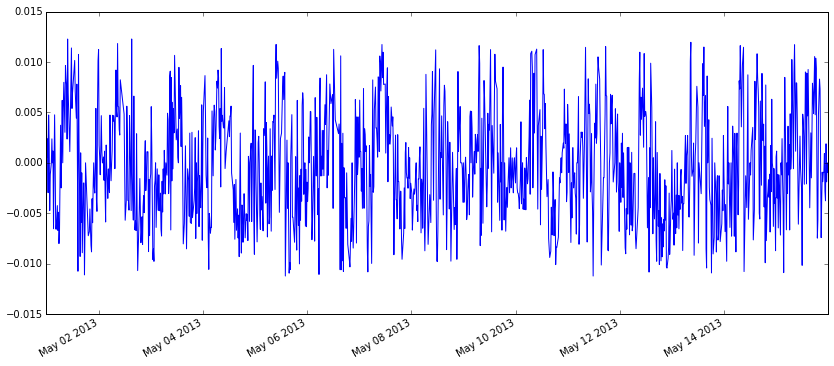

In [3]:
park_ts_logr = (np.log(park_ts / park_ts.shift(1)))[1:]
basic_stats = park_ts_logr.describe(percentiles=[0.05, 0.95])

print(basic_stats)
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out
outliers to get a properly scaled figure.

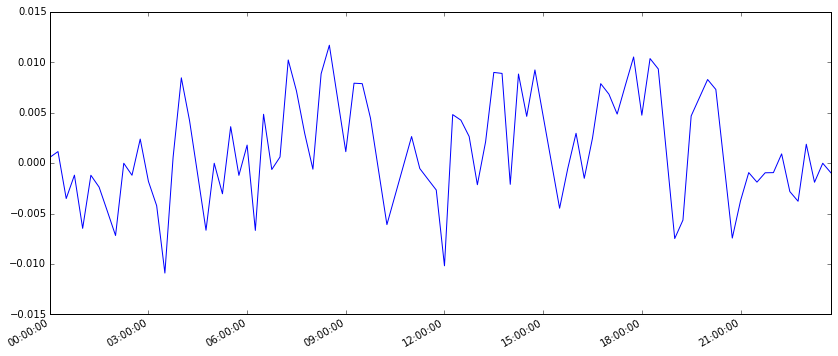

In [4]:
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96
(our data points are spaced at 15 minute intervals),
and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [5]:
print(sarimax.SARIMAX(park_ts_logr.loc['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                1267.809
Date:                            Mon, 20 Jul 2015   AIC                          -2531.618
Time:                                    13:04:55   BIC                          -2523.271
Sample:                                05-06-2013   HQIC                         -2528.337
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.3477      0.044      7.946      0.000         0.262     0.433
sigma2      7.937e-05   5.93e-06     13.392      0.000      6.78e-05   9.1e-05


While the fit isn't terrible, it perhaps can be improved by first observing
that we have spikes in our at the beginning of the day. This is due to
the ratio of consecutive values dipping suddenly at the end of day
as systems are ramped down.
Observe that the only negative values in the data occur at the start of
day. We filter these out, and re-run SARIMA.

In [6]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  221
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                 432.385
Date:                            Mon, 20 Jul 2015   AIC                           -860.770
Time:                                    13:04:59   BIC                           -853.973
Sample:                                05-06-2013   HQIC                          -858.025
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.3837      0.070      5.477      0.000         0.246     0.521
sigma2       6.11e-05      8e-06      7.638      0.000      4.54e-05  7.68e-05


Our data is clustered very close to the mean--i.e, the spikes are very small spikes. Consequently, the positive of filtering them out (i.e. smoothing the data) outweighs the drawback of reducing the number of points to fit. 

Now, let's use a larger input
(beginning on a Monday, and ending on a Friday), and fit another
Sarimax model to our beginning-of-day spike-filtered data.

In [7]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1369
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                4508.439
Date:                            Mon, 20 Jul 2015   AIC                          -9012.877
Time:                                    13:05:13   BIC                          -9002.433
Sample:                                05-06-2013   HQIC                         -9008.969
                                     - 06-07-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.3690        nan        nan        nan           nan       nan
sigma2      4.939e-05   1.91e-06     25.912      0.000      4.57e-05  5.31e-05


/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


As expected, this is an even better fit than the fit for the week's worth of data.
Lastly, we input three # months worth of data, beginning on a Monday,
and ending on a Friday.

In [8]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 3891
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               14249.942
Date:                            Mon, 20 Jul 2015   AIC                         -28495.883
Time:                                    13:05:44   BIC                         -28483.351
Sample:                                05-06-2013   HQIC                        -28491.435
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.3752      0.013     29.563      0.000         0.350     0.400
sigma2      3.213e-05   7.68e-07     41.815      0.000      3.06e-05  3.36e-05


/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Let's contrast this with our fit when we include the end-of-day spikes:

In [9]:
print(sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 9120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood               31845.759
Date:                            Mon, 20 Jul 2015   AIC                         -63687.518
Time:                                    13:06:24   BIC                         -63673.282
Sample:                                05-06-2013   HQIC                        -63682.677
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2983      0.009     32.593      0.000         0.280     0.316
sigma2      5.039e-05   7.54e-07     66.803      0.000      4.89e-05  5.19e-05


Hence, it makes sense to keep the analysis of
15-minute ramp-up and ramp-down times together with the analysis of the remaining data.

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we
isolate the 5-day workweek into 5 chunks, and run SARIMAX on
each chunk separately.

In [10]:
print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 1,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 2,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 3,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 4,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1756
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                3655.119
Date:                            Mon, 20 Jul 2015   AIC                          -7306.239
Time:                                    13:07:56   BIC                          -7295.297
Sample:                                03-25-2013   HQIC                         -7302.195
                                     - 01-27-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.0657      0.024      2.695      0.007         0.018     0.113
sigma2         0.0007    2.5e-05     28.676      0.000         0.001     0.001
                                 Statespace Mod

Including the spikes gives:

In [11]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 0],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 1],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 2],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 3],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 4],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4992
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               11850.266
Date:                            Mon, 20 Jul 2015   AIC                         -23696.531
Time:                                    13:08:34   BIC                         -23683.500
Sample:                                03-25-2013   HQIC                        -23691.964
                                     - 03-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.0871      0.014      6.164      0.000         0.059     0.115
sigma2         0.0005    9.7e-06     47.754      0.000         0.000     0.000
                                 Statespace Mod

##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week,
due to difference between system-idling over weekends and weekdays.

In [12]:
print(arima.ARIMA(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)],
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1966
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5402.102
Method:                           css   S.D. of innovations              0.016
Date:                Mon, 20 Jul 2015   AIC                         -10800.204
Time:                        13:09:15   BIC                         -10789.037
Sample:                    03-25-2013   HQIC                        -10796.100
                         - 01-27-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       9.371e-06      0.000      0.027      0.979        -0.001     0.001


Observe that between end of day and start of day, chilled water temperature
decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each
entry in our training set. The set $\{a_k\}_k$ will hopefully consist of
entries that are clustered near one another, with some reasonable volatility.
Taking a logarithm of them will result in an exponential increase in
volatility, since $log(x)$ is an exponential function of $x$ for decreasing
$x < 1$. This will result in decreasing the goodness-of-fit of a linear
model, from a least-squares standpoint. Consequently, we exponentiate our
time series data, and re-fit:

In [13]:
print(arima.ARIMA(np.exp(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)]),
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1966
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5621.070
Method:                           css   S.D. of innovations              0.014
Date:                Mon, 20 Jul 2015   AIC                         -11238.139
Time:                        13:09:15   BIC                         -11226.972
Sample:                    03-25-2013   HQIC                        -11234.035
                         - 01-27-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        9.25e-06      0.000      0.030      0.976        -0.001     0.001


Observe that the fit has improved, though not dramatically like for some of our other time series. This is due to Monday ramp-up values being very close to the mean. In general, our time series values are clustered very close together throughout the week. 